## msprime `from_species_tree` development

Need:
* Number of samples per species for generating sequence data
* Need to get a newick phylogeny out of the model@modelSteps[[1]]@metaComm

TODOs:
* Printing a roleModel@modelSteps to the screen is a text wall. Can we do this more gracefully?
* Timescale of the phylogeny (myr vs generations)
* msprime.Demography.from_species_tree() is very picky about ultrametricity. All nodes must be within 1e-8 of time zero. The ape->newick translation _sometimes_ results in tips that violate this requirement and it errors out:
```
ValueError: All leaf populations must be at time 0: time=2.8421709430404007e-08
```

Useful documentation:
* [roleR API diagram](https://docs.google.com/presentation/d/1IGeHnl9yG7C5y3i5lUpm2FWW2TyhJsf3_E00nKTNU-A/edit)
* [role intro vignette](https://htmlpreview.github.io/?https://github.com/role-model/roleR/blob/main/vignettes/roleR_use_cases.html)

Input:
* Phylogeny in newick format
* Vector of metacommunity abundances
* Local community
  * Abundances
  * Migration rates (Migrants per timestep: M_0/J_M * m)
  * Divergence times in generations

Output:
* Sequence data for local community species
* Pi? Dxy? TajD?

Install msprime:

    conda install -c conda-forge msprime pandas
    conda install -c bioconda python-newick

Install for testing and dev inside jupyter notebooks:

    conda install -c conda-forge rpy2 r-irkernel

Install RoLE Model:

    ## Some part of this 'fixes' the install for gmp inside R
    conda install -c conda-forge r-fs r-partitions
    install.packages("remotes")
    library(remotes)
    remotes::install_github("ajrominger/pika",dependencies=TRUE)
    remotes::install_github("role-model/roleR",dependencies=TRUE)    



In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

import msprime
import newick
import numpy as np
import pandas as pd

from collections import Counter, defaultdict
from IPython.display import display


## Simple as possible msprime species tree

In [3]:
tree = "(A:10.0,B:10.0)C"
initial_size = {"A": 1000, "B": 2000, "C": 100}
demography = msprime.Demography.from_species_tree(tree, initial_size)

## Parameterize and run a role simulation

In [273]:
%%R -o model -o individuals_meta -o individuals_local -o curtime -o metaAbund -o localAbund -o localTDiv -o localComm
library(roleR)
library(ape)

targetStep = 3

p <- roleParams(individuals_local = 100, individuals_meta = 10000,
                         species_meta = 20, speciation_local = 0, 
                         speciation_meta = 0.05, extinction_meta = 0.05, env_sigma = 0.5,
                         trait_sigma=1,comp_sigma = 0.5, dispersal_prob = 0.1, mutation_rate = 0.01,
                         equilib_escape = 1, num_basepairs = 250,
                         init_type = 'oceanic_island', niter = 1000, niterTimestep = 100)
model <- runRole(roleModel(p))

## TODO: Broken by iterFuns
##exp = as(model, "roleExperiment")
##curtime = exp@experimentMeta$iterations[[targetStep]]
curtime = 300

print("  model slots")
print(slotNames(model))
print("  params slots")
print(slotNames(model@params))
print("  model step slots")
print(slotNames(model@modelSteps[[targetStep]]))
print("  metaComm slots")
print(slotNames(model@modelSteps[[targetStep]]@metaComm))
print("  localComm slots")
print(slotNames(model@modelSteps[[targetStep]]@localComm))

individuals_meta <- model@params@individuals_meta
## TODO: Broken by iterFuns
individuals_local <- model@params@individuals_local
individuals_local <- 100

metaAbund <- model@modelSteps[[targetStep]]@metaComm@spAbund
localAbund <- model@modelSteps[[targetStep]]@localComm@spAbund
localTDiv <- model@modelSteps[[targetStep]]@localComm@spLastOriginStep

localComm <- model@modelSteps[[targetStep]]@localComm

[1] "  model slots"
[1] "params"     "modelSteps"
[1] "  params slots"
 [1] "individuals_local" "individuals_meta"  "species_meta"     
 [4] "speciation_local"  "speciation_meta"   "extinction_meta"  
 [7] "dispersal_prob"    "trait_sigma"       "env_sigma"        
[10] "comp_sigma"        "neut_delta"        "env_comp_delta"   
[13] "mutation_rate"     "equilib_escape"    "alpha"            
[16] "num_basepairs"     "init_type"         "niter"            
[19] "niterTimestep"    
[1] "  model step slots"
[1] "localComm" "metaComm"  "phylo"    
[1] "  metaComm slots"
[1] "spAbund" "spTrait"
[1] "  localComm slots"
 [1] "indSpecies"       "indTrait"         "indSeqs"          "spGenDiv"        
 [5] "spTrait"          "spAbund"          "spAbundHarmMean"  "spLastOriginStep"
 [9] "spExtinctionStep" "equilibProp"     


## Construct ape phylogeny from one simulation timestep

In [170]:
%%R
newick <- function(phylo){
     ape_tree <- as(phylo, "phylo")
     ## Force ultrametric from phytools:
     ## http://blog.phytools.org/2017/03/forceultrametric-method-for-ultrametric.html
     ## phytools force.ultrametric DOES NOT WORK!
     ##ape_tree <- force.ultrametric(ape_tree, message=FALSE)
     ## digits=20 is necessary to prevent floating point rounding errors from nudging the tree out of ultrametricity
     write.tree(ape_tree, file = 'temp.nwk', append = FALSE, digits = 40, tree.names = FALSE)
     nwk <- readChar('temp.nwk', file.info('temp.nwk')$size)
     #unlink('temp.nwk')
     nwk
}


[1] TRUE
[1] "((((t13:2.293534133046868817018548725172877311707,t10:2.293534133046868817018548725172877311707):138.828429935434996878029778599739074707,(((t6:11.04695534423778724431031150743365287781,t12:11.04695534423778724431031150743365287781):19.15197232526100279415004479233175516129,t7:30.19892766949879003846035629976540803909):65.15473805538903206979739479720592498779,(t8:43.26469045312495609323377721011638641357,((t11:15.42787765266600530367213650606572628021,(t20:1.77711420126415475806425092741847038269,t2:1.77711420126415475806425092741847038269):13.65076345140185054560788557864725589752):25.16165770975488413796483655460178852081,((t14:2.573986406433633078449929598718881607056,t19:2.573986406433633078449929598718881607056):11.68972169899095092659990768879652023315,t4:14.26370810542458400504983728751540184021):26.32582725699630543658713577315211296082):2.675155090704066651596804149448871612549):52.08897527176286246231029508635401725769):45.76829834359405424493161262944340705872

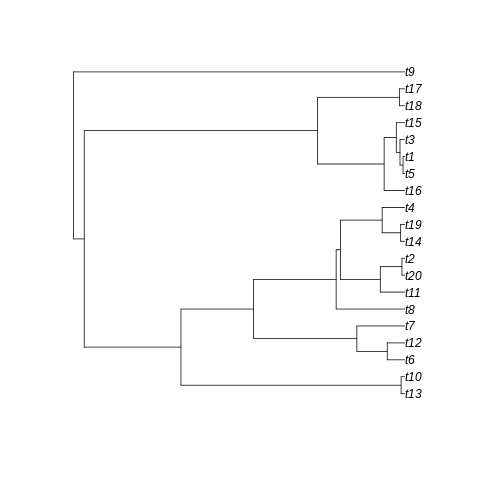

In [274]:
%%R -o nwk
nwk <- newick(model@modelSteps[[4]]@phylo)
tre <- read.tree(text=nwk)
plot(tre)
print(is.ultrametric(tre, tol=0.0000000000025))
print(nwk)


In [214]:
import toytree
parse_newick(nwk[0], 10**6)
ntree = toytree.tree(nwk[0], tree_format=0)
_ = ntree.draw()

Node("t6") 0.0 0.5579491767486289
Node("t1") 0.0 0.5579491767486289
Node("t4") 0.0 7.033958265338313
Node("t9") 0.0 24.368542800122427
Node("t7") 0.0 3.38069391963505
Node("t2") 0.0 2.1445478962475164
Node("t3") 0.0 2.1445478962475164
Node("t16") 0.0 19.173046903840707
Node("t13") 0.0 8.963353356005854
Node("t8") 0.0 2.6574353194952494
Node("t12") 0.0 2.6574353194952494
Node("t18") 0.0 3.0683655078757894
Node("t19") 0.0 13.189646548878237
Node("t20") 0.0 24.525264736195307
Node("t10") 0.0 16.850238049354857
Node("t14") 0.0 16.850238049354857
Node("t15") 0.0 26.99954131860849
Node("t17") 0.0 51.2662585287948
Node("t5") 0.0 1.8064742393532498
Node("t11") 0.0 1.8064742393532498


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="265.0px" height="360.0px" viewBox="0 0 265.0 360.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t991a4bb4ab034e97b19924f8e1a0488e"> t12 t8 t18 t13 t19 t16 t20 t14 t10 t15 t1 t6 t4 t9 t3 t2 t7 t11 t5 t17

## Get the rest of the necessary data

In [275]:
from collections import Counter, OrderedDict
local_sad = {int(x):y for x,y in Counter(localComm.slots["indSpecies"]).items()}
print(local_sad)

## Enumerate +1 for 1-indexed species names
meta_sad = {x+1:y*individuals_meta[0] for x,y in enumerate(metaAbund)}
print(meta_sad)
## -1 so lidx indices from 1-idexed species names properly index indo localTDiv array
lidx = np.array(list(local_sad.keys()))-1
## Get tdiv in generations before present
## Subtract localTDiv from curtime (current time in iterations) and divide by iterations per generation (J/2)
tdiv = {x+1:(curtime[0]-y)/(individuals_local[0]/2) for x,y in zip(lidx, localTDiv[lidx])}
print(tdiv)

{1: 87, 9: 4, 2: 4, 3: 2, 5: 3}
{1: 4796.8296494753295, 2: 2094.217459254298, 3: 1166.5550346059388, 4: 702.16566197812, 5: 438.7139986604153, 6: 280.19647242688103, 7: 180.8439383791025, 8: 117.21366376423309, 9: 77.02612190221032, 10: 50.234427327528465, 11: 33.48961821835231, 12: 21.210091538289795, 13: 14.512167894619335, 14: 8.930564858227283, 15: 6.697923643670462, 16: 4.465282429113642, 17: 2.232641214556821, 18: 2.232641214556821, 19: 1.1163206072784104, 20: 1.1163206072784104}
{1: 6.0, 9: 4.78, 2: 5.74, 3: 2.48, 5: 3.18}


## Make a data frame

    full_df - all meta and local community data
    loc_df - only species present in the local community

In [276]:
## Make dataframe from list of dictionaries where all keys are species IDs
full_df = pd.DataFrame([local_sad, meta_sad, tdiv], index=["local_abund", "meta_abund", "tdiv"])
## Sort columns ascending
full_df = full_df[sorted(full_df.columns)]
## Update column names to match species tree tip labels
full_df.columns = ["t{}".format(x) for x in full_df.columns]
## Create a new dict for just the species present in the local community
local_df = full_df.dropna(subset=["local_abund"], axis=1)
display(full_df)
local_df

t1           t2           t3          t4          t5   
local_abund    87.000000     4.000000     2.000000         NaN    3.000000  \
meta_abund   4796.829649  2094.217459  1166.555035  702.165662  438.713999   
tdiv            6.000000     5.740000     2.480000         NaN    3.180000   

                     t6          t7          t8         t9        t10   
local_abund         NaN         NaN         NaN   4.000000        NaN  \
meta_abund   280.196472  180.843938  117.213664  77.026122  50.234427   
tdiv                NaN         NaN         NaN   4.780000        NaN   

                   t11        t12        t13       t14       t15       t16   
local_abund        NaN        NaN        NaN       NaN       NaN       NaN  \
meta_abund   33.489618  21.210092  14.512168  8.930565  6.697924  4.465282   
tdiv               NaN        NaN        NaN       NaN       NaN       NaN   

                  t17       t18       t19       t20  
local_abund       NaN       NaN       NaN       NaN  
meta_abund   2.232641  2.232641  1.116321  1.116321  
tdiv              NaN       NaN       NaN       NaN

t1           t2           t3          t5         t9
local_abund    87.000000     4.000000     2.000000    3.000000   4.000000
meta_abund   4796.829649  2094.217459  1166.555035  438.713999  77.026122
tdiv            6.000000     5.740000     2.480000    3.180000   4.780000

In [277]:
## hacking an alpha value to scale metacommunity abundance to a 'reasonable' Ne
alpha = 1000
## format the metacommunity abundances as a dictionary to pass in to msprime
meta_Nes = (full_df.loc["meta_abund"]*alpha).to_dict()
## Create a default dict so internal nodes have a default Ne. Arbitrarily set to 10,000.
meta_Nes = defaultdict(lambda: 10000, meta_Nes)
meta_Nes

defaultdict(<function __main__.<lambda>()>,
            {'t1': 4796829.64947533,
             't2': 2094217.459254298,
             't3': 1166555.0346059387,
             't4': 702165.6619781201,
             't5': 438713.9986604153,
             't6': 280196.472426881,
             't7': 180843.9383791025,
             't8': 117213.66376423309,
             't9': 77026.12190221032,
             't10': 50234.427327528465,
             't11': 33489.61821835231,
             't12': 21210.091538289795,
             't13': 14512.167894619335,
             't14': 8930.564858227284,
             't15': 6697.923643670462,
             't16': 4465.282429113642,
             't17': 2232.641214556821,
             't18': 2232.641214556821,
             't19': 1116.3206072784105,
             't20': 1116.3206072784105})

## Create the msprime demography from newick

In [278]:
## Set initial size of all metacommunity lineages from the full_df
demography = msprime.Demography.from_species_tree(nwk[0],
                                                  initial_size=meta_Nes,
                                                  time_units="myr",
                                                  generation_time=1)

ValueError: All leaf populations must be at time 0: time=2.8421709430404007e-08

In [28]:
demography

Demography(populations=[Population(initial_size=6905455.005695481, growth_rate=0.0, name='t1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=1265.6625743576765, growth_rate=0.0, name='t10', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=2531.325148715353, growth_rate=0.0, name='t9', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=273383.1160612581, growth_rate=0.0, name='t4', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=107581.31882040249, growth_rate=0.0, name='t5', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=4), Population(initial_size=1938995.0639159603, growth_rate=0.0, name='t2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=5), Population(initial_size=6328.312871788381, growth_rate=0.0, name='t8', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=6), Population(initial_size=17719.27604100747, growth_rate=0.0, name='t7', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=7), Population(initial_size=703708.3913428679, growth_rate=0.0, name='t3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=8), Population(initial_size=43032.527528160994, growth_rate=0.0, name='t6', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=9), Population(initial_size=10000, growth_rate=0.0, name='pop_10', description='', extra_metadata={}, default_sampling_time=24778582.32017458, initially_active=False, id=10), Population(initial_size=10000, growth_rate=0.0, name='pop_11', description='', extra_metadata={}, default_sampling_time=4472820.232087436, initially_active=False, id=11), Population(initial_size=10000, growth_rate=0.0, name='pop_12', description='', extra_metadata={}, default_sampling_time=4718221.3426087005, initially_active=False, id=12), Population(initial_size=10000, growth_rate=0.0, name='pop_13', description='', extra_metadata={}, default_sampling_time=3828831.8329769312, initially_active=False, id=13), Population(initial_size=10000, growth_rate=0.0, name='pop_14', description='', extra_metadata={}, default_sampling_time=23636273.739565253, initially_active=False, id=14), Population(initial_size=10000, growth_rate=0.0, name='pop_15', description='', extra_metadata={}, default_sampling_time=45452496.67278131, initially_active=False, id=15), Population(initial_size=10000, growth_rate=0.0, name='pop_16', description='', extra_metadata={}, default_sampling_time=47368307.045303605, initially_active=False, id=16), Population(initial_size=10000, growth_rate=0.0, name='pop_17', description='', extra_metadata={}, default_sampling_time=43711789.363643706, initially_active=False, id=17), Population(initial_size=10000, growth_rate=0.0, name='pop_18', description='', extra_metadata={}, default_sampling_time=66448465.96360503, initially_active=False, id=18)], events=[PopulationSplit(time=3828831.8329769312, derived=['t2', 't8'], ancestral='pop_13'), PopulationSplit(time=4472820.232087436, derived=['t4', 't5'], ancestral='pop_11'), PopulationSplit(time=4718221.3426087005, derived=['t9', 'pop_11'], ancestral='pop_12'), PopulationSplit(time=23636273.739565253, derived=['pop_12', 'pop_13'], ancestral='pop_14'), PopulationSplit(time=24778582.32017458, derived=['t1', 't10'], ancestral='pop_10'), PopulationSplit(time=43711789.363643706, derived=['t3', 't6'], ancestral='pop_17'), PopulationSplit(time=45452496.67278131, derived=['pop_10', 'pop_14'], ancestral='pop_15'), PopulationSplit(time=47368307.045303605, derived=['pop_15', 't7'], ancestral='pop_16'), PopulationSplit(time=66448465.96360503, derived=['pop_16', 'pop_17'], ancestral='pop

## Update msprime demography with local populations

In [264]:
demography = msprime.Demography.from_species_tree(nwk[0],
                                                  initial_size=meta_Nes,
                                                  time_units="myr",
                                                  generation_time=1)

## Fudge factor because time in the local community is very short in the toy sims (~10 generations)
time_mod=1000

display(local_df)
for sp in local_df:
    meta_sp = f"{sp}_m"
    local_sp = f"{sp}_l"
    local_Ne = local_df[sp]["local_abund"]*alpha
    tdiv = local_df[sp]["tdiv"]*time_mod
    demography.add_population(name=meta_sp, initial_size=meta_Nes[sp])
    demography.add_population(name=local_sp, initial_size=local_Ne)
    demography.add_population_split(time=tdiv, derived=[meta_sp, local_sp], ancestral=sp)
    ## Strong colonization bottleneck after colonization
    demography.add_instantaneous_bottleneck(time=tdiv-1, strength=2*local_Ne, population=local_sp)

demography.sort_events()
demography

t1           t2          t4          t5          t6   
local_abund    17.000000     6.000000    2.000000    3.000000    1.000000  \
meta_abund   4796.829649  2094.217459  702.165662  438.713999  280.196472   
tdiv           19.640000    18.400000   19.860000   18.900000   16.200000   

                     t7  
local_abund   71.000000  
meta_abund   180.843938  
tdiv          20.000000

Demography(populations=[Population(initial_size=2094217.459254298, growth_rate=0.0, name='t2', description='', extra_metadata={}, default_sampling_time=18400.0, initially_active=False, id=0), Population(initial_size=1116.3206072784105, growth_rate=0.0, name='t20', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=1166555.0346059387, growth_rate=0.0, name='t3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=180843.9383791025, growth_rate=0.0, name='t7', description='', extra_metadata={}, default_sampling_time=20000.0, initially_active=False, id=3), Population(initial_size=14512.167894619335, growth_rate=0.0, name='t13', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=4), Population(initial_size=702165.6619781201, growth_rate=0.0, name='t4', description='', extra_metadata={}, default_sampling_time=19860.0, initially_active=False, id=5), Population(initial_size=8930.564858227284, growth_rate=0.0, name='t14', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=6), Population(initial_size=2232.641214556821, growth_rate=0.0, name='t18', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=7), Population(initial_size=4465.282429113642, growth_rate=0.0, name='t16', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=8), Population(initial_size=1116.3206072784105, growth_rate=0.0, name='t19', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=9), Population(initial_size=21210.091538289795, growth_rate=0.0, name='t12', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=10), Population(initial_size=438713.9986604153, growth_rate=0.0, name='t5', description='', extra_metadata={}, default_sampling_time=18900.0, initially_active=False, id=11), Population(initial_size=2232.641214556821, growth_rate=0.0, name='t17', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=12), Population(initial_size=117213.66376423309, growth_rate=0.0, name='t8', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=13), Population(initial_size=4796829.64947533, growth_rate=0.0, name='t1', description='', extra_metadata={}, default_sampling_time=19640.0, initially_active=False, id=14), Population(initial_size=77026.12190221032, growth_rate=0.0, name='t9', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=15), Population(initial_size=50234.427327528465, growth_rate=0.0, name='t10', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=16), Population(initial_size=33489.61821835231, growth_rate=0.0, name='t11', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=17), Population(initial_size=280196.472426881, growth_rate=0.0, name='t6', description='', extra_metadata={}, default_sampling_time=16200.0, initially_active=False, id=18), Population(initial_size=6697.923643670462, growth_rate=0.0, name='t15', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=19), Population(initial_size=10000, growth_rate=0.0, name='pop_20', description='', extra_metadata={}, default_sampling_time=5506304.559520757, initially_active=False, id=20), Population(initial_size=10000, growth_rate=0.0, name='pop_21', description='', extra_metadata={}, default_sampling_time=1034835.323354173, initially_active=False, id=21), Population(initial_size=10000, growth_rate=0.0, name='pop_22', description='', extra_metadata={}, default_sampling_time=6974218.488307713, initially_active=False, id=22), Population(initial_size=10000, growth_rate=0.0, name='pop_23', description='', extra_metadata={}, default_sampling_time=10919853.6494

## Simulate ancestry and mutations

In [265]:
ts = msprime.sim_ancestry(
    samples={f"{sp}_l":5 for sp in local_df},
            demography=demography,
            sequence_length=250,
            ploidy=1,
            random_seed=2)
ts

In [266]:
mu = 1e-7
ts = msprime.sim_mutations(ts, rate=mu)
ts

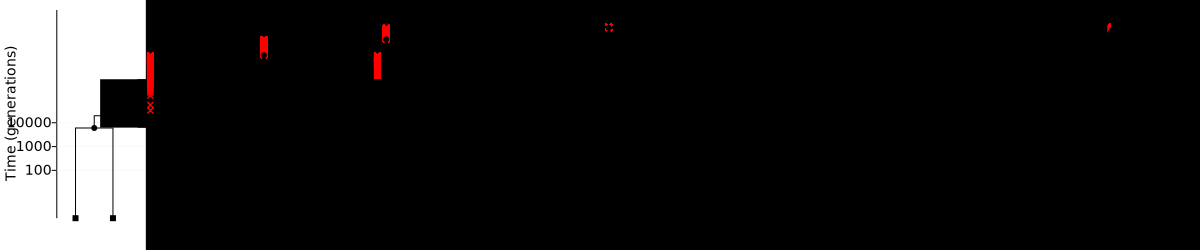

In [268]:
wide_fmt = (1200, 250)
# Create a stylesheet that shrinks labels and rotates leaf labels, to avoid overlap
node_label_style = (
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)
nd_labels = {}  # An array of labels for the nodes
for n in ts.nodes():
    # Set sample node labels from metadata. Here we use the population name, but you might want
    # to use the *individual* name instead, if the individuals in your tree sequence have names
    if n.is_sample():
        nd_labels[n.id] = ts.population(n.population).metadata["name"]

ts.first().draw_svg(
    size=wide_fmt,
    time_scale="log_time",
    y_gridlines=True,
    y_axis=True,
    y_ticks=[100, 1000, 10000],
    node_labels=nd_labels,
    mutation_labels=defaultdict(lambda:''),
    style=node_label_style,
)


## Fetch pi, tajD, & genotype data for each sampled population

In [120]:
## Get a dictionary mapping population ids to the list of node IDs per population
nodeIDs = defaultdict(lambda: [])
for n in ts.nodes():
    if n.is_sample():
        nodeIDs[ts.population(n.population).metadata["name"]].append(n.id)

nodeIDs

defaultdict(<function __main__.<lambda>()>,
            {'t1_l': [0, 1, 2, 3, 4],
             't2_l': [5, 6, 7, 8, 9],
             't3_l': [10, 11, 12, 13, 14],
             't6_l': [15, 16, 17, 18, 19]})

In [126]:
res = {}
for popname, idxs in nodeIDs.items():
    print(popname, idxs)
    ## Split off the _l so the pop name agrees with the name in local_df
    pname = popname.split("_")[0]
    res[pname] = []
    res[pname].append(ts.diversity(sample_sets=idxs))
    res[pname].append(ts.Tajimas_D(sample_sets=idxs))
#    res[pname].append(ts.genotype_matrix(samples=idxs).T)
    res[pname].append(list(ts.haplotypes(samples=idxs)))
res_df = pd.DataFrame(res, index=["pi", "TajD", "gtypes"])
pd.concat([local_df, res_df])
res_df

t1_l [0, 1, 2, 3, 4]
t2_l [5, 6, 7, 8, 9]
t3_l [10, 11, 12, 13, 14]
t6_l [15, 16, 17, 18, 19]


t1   
pi                                                    0.0  \
TajD                                                  NaN   
gtypes  [ATAGGTCAATAGTATTGCCGAACACGCCGAGTAACACCGCGCAGG...   

                                                       t2   
pi                                                 0.0056  \
TajD                                            -0.174749   
gtypes  [ATAGGACTTATATGTGTAGGAGAGACTATGAGTTAGTACTCCGAC...   

                                                       t3   
pi                                                    0.0  \
TajD                                                  NaN   
gtypes  [GGCGCACGACTCGGTTGCGCCACGTCCCTGTGCATGATGCATGGG...   

                                                       t6  
pi                                                 0.0024  
TajD                                             1.224745  
gtypes  [TACCCACGAGGAGCGTATGAAGCCGCACATCAAAACGAAATCTTA...

In [124]:
list(ts.haplotypes(samples=[0, 1, 2, 3, 4]))

['ATAGGTCAATAGTATTGCCGAACACGCCGAGTAACACCGCGCAGGACGCTCTAAGCACCTGATAGTCCGCTATGACACTTCACCGCGAAAGAGCAATTTCCGCCGGGGTCCTCAGTAGGGTACACATCCCCCTGACCACTTAAAAGAAAGATGATATGACTACATCTCAAAGACACCAGGGTAGTTTCAATAAATGCTAAATAGATCGCGTGGCTGGGTTCTAGGCCCTAGCACTAATCAAAGTCTCTCT',
 'ATAGGTCAATAGTATTGCCGAACACGCCGAGTAACACCGCGCAGGACGCTCTAAGCACCTGATAGTCCGCTATGACACTTCACCGCGAAAGAGCAATTTCCGCCGGGGTCCTCAGTAGGGTACACATCCCCCTGACCACTTAAAAGAAAGATGATATGACTACATCTCAAAGACACCAGGGTAGTTTCAATAAATGCTAAATAGATCGCGTGGCTGGGTTCTAGGCCCTAGCACTAATCAAAGTCTCTCT',
 'ATAGGTCAATAGTATTGCCGAACACGCCGAGTAACACCGCGCAGGACGCTCTAAGCACCTGATAGTCCGCTATGACACTTCACCGCGAAAGAGCAATTTCCGCCGGGGTCCTCAGTAGGGTACACATCCCCCTGACCACTTAAAAGAAAGATGATATGACTACATCTCAAAGACACCAGGGTAGTTTCAATAAATGCTAAATAGATCGCGTGGCTGGGTTCTAGGCCCTAGCACTAATCAAAGTCTCTCT',
 'ATAGGTCAATAGTATTGCCGAACACGCCGAGTAACACCGCGCAGGACGCTCTAAGCACCTGATAGTCCGCTATGACACTTCACCGCGAAAGAGCAATTTCCGCCGGGGTCCTCAGTAGGGTACACATCCCCCTGACCACTTAAAAGAAAGATGATATGACTACATCTCAAAGACACCAGGGTAGTTTCAATAAATGCTAAATAGATCGCGTGGCTGGGTTCTAGGCCCTAGCA

# Trash below here

## Debugging newick trees

In [256]:
#msprime.species_trees.parse_newick(nwk[0], 10**6)
def parse_newick(tree, branch_length_multiplier):
    """
    Parses the newick tree and annotates the resulting nodes with their
    time values, appropriately scaled.
    """
    # Parse the newick tree string.
    parsed = newick.loads(tree)
    if len(parsed) == 0:
        raise ValueError(f"Not a valid newick tree: '{tree}'")
    root = parsed[0]

    # Set node depths (distances from root).
    stack = [(root, 0)]
    num_nodes = 0
    max_depth = 0
    while len(stack) > 0:
        node, depth = stack.pop()
        if depth > max_depth:
            max_depth = depth
        num_nodes += 1
        node.depth = depth
        for child in node.descendants:
            stack.append((child, depth + child.length))
    if num_nodes < 3:
        raise ValueError("Newick tree must have at least three nodes")

    # Set node times (distances from present).
    for node in root.walk():
        node.time = (max_depth - node.depth) * branch_length_multiplier
        print(node.name, node.is_leaf, node.time)
        # We don't allow non ultrametric trees for now because it's unclear
        # how we should deal with taking samples in this case. The code
        # all works perfectly well other than this, though.
        if node.is_leaf:
            if abs(node.time) > 1e-8:  # Arbitrary cutoff
                raise ValueError(
                    f"All leaf populations must be at time 0: time={node.time}"
                )
        print(node.name, node.is_leaf, node.time)
    return root
#t = parse_newick(nwk[0], 10**6)
print()
#for node in t.walk():
#    print(node, node.time, node.length, node._length)

wat = "(((((t6:2.45112382300675335500272922218,t8:2.45112382300675335500272922218):9.79658819007364911612967262045,t3:12.2477120130804024711324018426):0.274339041983090226040076231584,t4:12.5220510550634926971724780742):18.933448771541357302794494899,t10:31.4554998266048499999669729732):121.547048353778492923993326258,(((t5:1.18211007899886055838578613475,t1:1.18211007899886055838578613475):2.39764699703194139601691858843,(t7:0.98689255753362914447279763408,t2:0.98689255753362914447279763408):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.9234924792783907321336300811):133.07905570110494863911299035);"
print(wat)
wat = _force_ultrametric(wat)
print(wat)
t = parse_newick(wat, 10**6)
print(wat)
t.newick


(((((t6:2.45112382300675335500272922218,t8:2.45112382300675335500272922218):9.79658819007364911612967262045,t3:12.2477120130804024711324018426):0.274339041983090226040076231584,t4:12.5220510550634926971724780742):18.933448771541357302794494899,t10:31.4554998266048499999669729732):121.547048353778492923993326258,(((t5:1.18211007899886055838578613475,t1:1.18211007899886055838578613475):2.39764699703194139601691858843,(t7:0.98689255753362914447279763408,t2:0.98689255753362914447279763408):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.9234924792783907321336300811):133.07905570110494863911299035);
None 0.0
None 121.5470483537785
None 18.933448771541357
None 0.2743390419830902
None 9.79658819007365
t6 2.4511238230067534
t8 2.4511238230067534
t3 12.247712013080402
t4 12.522051055063521
t10 31.45549982660488
None 133.07905570110495
None 16.34373540324759
None 2.3976469970319414
t5 1.1821100789989174
t1 1.1821100789989174
None 2.592864518497173
t7 0.9868925575336576
t2 

'(((((t6:2.4511238230067534,t8:2.4511238230067534):9.79658819007364911612967262045,t3:12.247712013080402):0.274339041983090226040076231584,t4:12.522051055063521):18.933448771541357302794494899,t10:31.45549982660488):121.547048353778492923993326258,(((t5:1.1821100789989174,t1:1.1821100789989174):2.39764699703194139601691858843,(t7:0.9868925575336576,t2:0.9868925575336576):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.92349247927842):133.07905570110494863911299035)'

In [198]:
import toytree
print(t.newick)
print(nwk[0])
#ntree = toytree.tree(nwk[0], tree_format=0)
_ = ntree.draw()

(((t8:23.23024077574185142225360323209315538406,t5:23.23024077574185142225360323209315538406):24.26146708828785492073620844166725873947,((t2:8.072970319062299893175804754719138145447,t7:8.072970319062299893175804754719138145447):19.73836336416463055343228916171938180923,t3:27.81133368322693044660809391643851995468):19.68037418080277589638171775732189416885):22.48603930835695052792289061471819877625,((t1:7.183044919322398413896735291928052902222,t10:7.183044919322398413896735291928052902222):4.833259304519728516424947883933782577515,(t9:4.754958914543507830785529222339391708374,(t6:2.768425059009238964335963828489184379578,t4:2.768425059009238964335963828489184379578):1.986533855534268866449565393850207328796):7.261345309298619099536153953522443771362):57.96144294854452994059101911261677742004)
(((t8:23.23024077574185142225360323209315538406,t5:23.23024077574185142225360323209315538406):24.26146708828785492073620844166725873947,((t2:8.072970319062299893175804754719138145447,t7:8.0729703

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="265.0px" height="275.0px" viewBox="0 0 265.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6315f325905e47e38676cacfe36a72a2"> t9 t5 t8 t6 t1 t2 t10 t3 t4 t7

In [255]:
def _force_ultrametric(tree):
    """
    Force all leaf nodes to time 0
    Input a newick tree in string format
    Output is a modified newick tree with all leafs having equal total length
    """
    # Parse the newick tree string.
    parsed = newick.loads(tree)
    if len(parsed) == 0:
        raise ValueError(f"Not a valid newick tree: '{tree}'")
    root = parsed[0]

    # Set node depths (distances from root).
    stack = [(root, 0)]
    max_depth = 0
    while len(stack) > 0:
        node, depth = stack.pop()
        if depth > max_depth:
            max_depth = depth
        node.depth = depth
        for child in node.descendants:
            stack.append((child, depth + child.length))
    for node in root.walk():
        if node.is_leaf:
            ## Add offset to node.length to foce all nodes to fall at time 0
            node.length = node.length + (max_depth - node.depth)
        print(node.name, node.length)
    return root.newick
wat = "(((((t6:2.45112382300675335500272922218,t8:2.45112382300675335500272922218):9.79658819007364911612967262045,t3:12.2477120130804024711324018426):0.274339041983090226040076231584,t4:12.5220510550634926971724780742):18.933448771541357302794494899,t10:31.4554998266048499999669729732):121.547048353778492923993326258,(((t5:1.18211007899886055838578613475,t1:1.18211007899886055838578613475):2.39764699703194139601691858843,(t7:0.98689255753362914447279763408,t2:0.98689255753362914447279763408):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.9234924792783907321336300811):133.07905570110494863911299035);"
_force_ultrametric(wat)

None 0.0
None 121.5470483537785
None 18.933448771541357
None 0.2743390419830902
None 9.79658819007365
t6 2.4511238230067534
t8 2.4511238230067534
t3 12.247712013080402
t4 12.522051055063521
t10 31.45549982660488
None 133.07905570110495
None 16.34373540324759
None 2.3976469970319414
t5 1.1821100789989174
t1 1.1821100789989174
None 2.592864518497173
t7 0.9868925575336576
t2 0.9868925575336576
t9 19.92349247927842


'(((((t6:2.4511238230067534,t8:2.4511238230067534):9.79658819007364911612967262045,t3:12.247712013080402):0.274339041983090226040076231584,t4:12.522051055063521):18.933448771541357302794494899,t10:31.45549982660488):121.547048353778492923993326258,(((t5:1.1821100789989174,t1:1.1821100789989174):2.39764699703194139601691858843,(t7:0.9868925575336576,t2:0.9868925575336576):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.92349247927842):133.07905570110494863911299035)'

In [27]:
import newick
print(newick.__version__)
print(nwk[0])
tree = newick.loads(nwk[0])[0]
print(tree.ascii_art())

1.7.0
(((((t1:12.81909994,(t8:4.50543671,t7:4.50543671):8.313663226):4.664673682,(t9:7.510527151,t3:7.510527151):9.973246468):26.24487534,(t5:14.08435921,t6:14.08435921):29.64428975):13.09992292,t2:56.82857188):20.44951288,(t10:21.04719718,t4:21.04719718):56.23088758);

                              ┌─t1
                        ┌─────┤
                        │     │     ┌─t8
                        │     └─────┤
                  ┌─────┤           └─t7
                  │     │     ┌─t9
            ┌─────┤     └─────┤
            │     │           └─t3
      ┌─────┤     │     ┌─t5
      │     │     └─────┤
      │     │           └─t6
──────┤     │
      │     └─t2
      │     ┌─t10
      └─────┤
            └─t4


In [205]:
ts_tmp = msprime.sim_ancestry(
    samples=[msprime.SampleSet(num_samples=5, population="t3_l", time=1000, ploidy=1),
            msprime.SampleSet(num_samples=5, population="t3_l", time=0, ploidy=1)],
            demography=demography,
            sequence_length=250,
            ploidy=1,
            random_seed=2)
ts_tmp = msprime.sim_mutations(ts_tmp, rate=mu*1)
ts_tmp.genotype_matrix().T

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 0]], dtype=int32)

## Trash

In [117]:
#s = pd.DataFrame([1,3,5,6], index=local_df.columns, columns=["pi"])
#pd.concat([local_df, s.T], axis=0)
res_df = pd.DataFrame(res, index=["pi", "TajD", "gtypes"])
pd.concat([local_df, res_df])

t1   
local_abund                                               68.0  \
meta_abund                                         6905.455006   
tdiv                                                      20.0   
pi                                                         0.0   
TajD                                                       0.0   
pi                                                         0.0   
TajD                                                       NaN   
gtypes       [[1, 3, 3, 3, 3, 1, 2, 1, 3, 3, 0, 0, 3, 2, 0,...   

                                                            t2   
local_abund                                               19.0  \
meta_abund                                         1938.995064   
tdiv                                                     18.16   
pi                                                         0.0   
TajD                                                       0.0   
pi                                                      0.0056   
TajD                                                 -0.174749   
gtypes       [[1, 3, 3, 3, 3, 3, 2, 3, 0, 2, 3, 2, 3, 1, 0,...   

                                                            t3   
local_abund                                                5.0  \
meta_abund                                          703.708391   
tdiv                                                     18.72   
pi                                                         0.0   
TajD                                                       0.0   
pi                                                         0.0   
TajD                                                       NaN   
gtypes       [[0, 0, 0, 3, 0, 3, 2, 0, 3, 0, 3, 1, 1, 1, 0,...   

                                                            t6  
local_abund                                                8.0  
meta_abund                                           43.032528  
tdiv                                                      9.26  
pi                                                         0.0  
TajD                                                       0.0  
pi                                                      0.0024  
TajD                                                  1.224745  
gtypes       [[2, 1, 0, 1, 0, 3, 2, 0, 3, 1, 2, 2, 1, 0, 1,...